# Define rare Adverse Drug Reactions (ADRs)

Import necessary modules: 

In [ ]:
import numpy as np
from ADRprofilePrediction import Pairs2Mat, evaluation
import matplotlib.pylab as plt
import json
import pandas as pd

In [2]:
import sklearn
print(sklearn.__version__)

0.24.2


## Load data

Load the feature data in to a dictionary. We used drug-gene interaction (DGI) as feature.

In [3]:
features_dict = {
    "DGI":Pairs2Mat(path="data/interactions.tsv",colname1="drug_claim_name",colname2="gene_name")
}


# Distribution of ADRs in SIDER and OFFSIDES

We visualized the distribution of ADRs in SIDER.

In [130]:
SEs = {}
SIDER = Pairs2Mat(path="data/drug_se.tsv",colname1="1_x",colname2="5")
column_sums = np.sum(SIDER, axis=0)

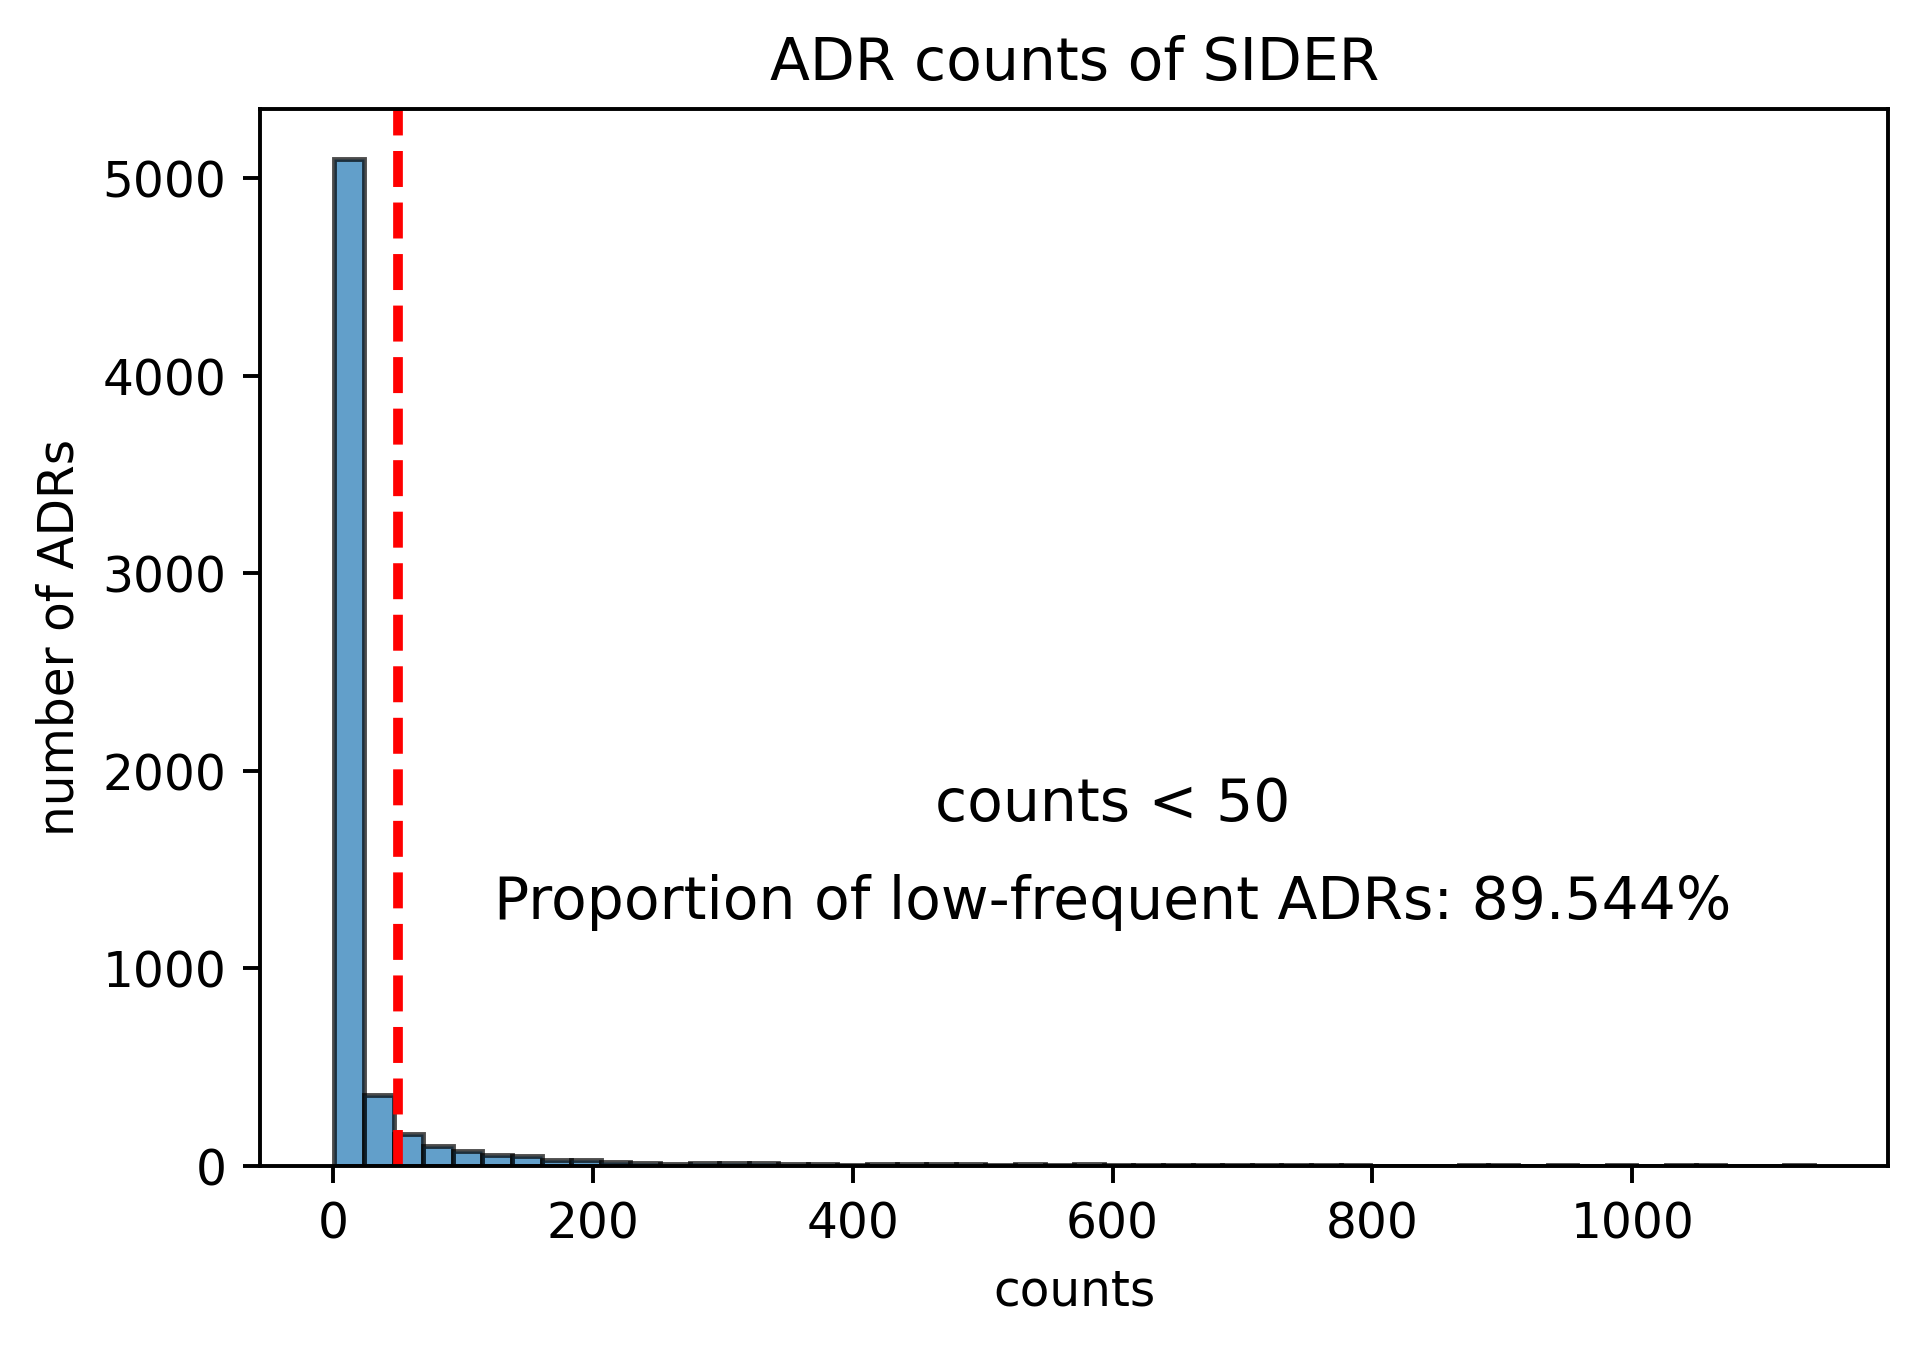

In [131]:
column_sums
plt.figure(dpi=350)
plt.hist(column_sums, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(x=50, color='red', linestyle='--', linewidth=2)
plt.title('ADR counts of SIDER')
plt.xlabel('counts')
plt.ylabel('number of ADRs')
prop = ((column_sums < 50).sum()/len(column_sums)).round(5)*100
plt.text(600, 1250, f'Proportion of low-frequent ADRs: {prop}%', color='black', fontsize=12, ha='center')
plt.text(600, 1750, "counts < 50", color='black', fontsize=12, ha='center')
plt.savefig(fname=f"figs/SIDER_rare.jpg", bbox_inches="tight")
plt.show()

The most frequent ADRs in SIDER are:

In [ ]:
pd.DataFrame(np.sum(SIDER, axis=0)/len(SIDER)).sort_values(0).tail(10)

,0
HYPERSENSITIVITY,0.647321
ASTHENIA,0.650298
PRURITUS,0.671875
DIARRHOEA,0.696429
DIZZINESS,0.735119
RASH,0.767113
VOMITING,0.768601
DERMATITIS,0.773065
HEADACHE,0.792411
NAUSEA,0.848214


The most infrequent ADRs in SIDER are:

In [298]:
rareADRs = (np.sum(SIDER, axis=0)).sort_values()
for i in rareADRs.index:
    print(i)

5'NUCLEOTIDASE INCREASED
DEAFNESS BILATERAL
NEUTROPHILIC DERMATOSIS
DARK CIRCLES UNDER EYES
NICOTINE DEPENDENCE
DACTYLITIS
NICOTINE POISONING
DACRYOCYSTITIS
DACRYOCANALICULITIS
DACRYOADENITIS ACQUIRED
CYTOTOXIC OEDEMA
NICOTINIC ACID DEFICIENCY
NICOTINIC EFFECTS
CYTOMEGALOVIRUS SYNDROME
CYTOMEGALOVIRUS HEPATITIS
CYTOMEGALOVIRUS GASTRITIS
NOCARDIOSIS
NOCTURIA AGGRAVATED
NOCTURNAL EMISSION
CYTOGENETIC ABNORMALITY
CYTARABINE SYNDROME
CYSTOCELE
CYSTITIS VIRAL
NON-ACCIDENTAL INJURY
NON-SMALL CELL LUNG CANCER
NONCONVULSIVE STATUS EPILEPTICUS
NONINFECTIOUS PERITONITIS
NONTOXIC GOITER
CYCLOTHYMIC DISORDER
NOSE INFECTION NOS
NEUTROPHIL PERCENTAGE INCREASED
NEUTROPENIA AGGRAVATED
NEUROTRANSMITTER LEVEL ALTERED
NEUROMUSCULAR TOXICITY
DEMYELINATION DISORDER NOS
NASOPHARYNGEAL DISORDER
DEMENTIA WITH LEWY BODIES
NAUSEA ALONE
NECK SWELLING
NEGATIVISM
NEISSERIA INFECTION
NEONATAL AND INFANCY DISORDER
DELIRIUM TREMENS
NEONATAL HYPONATRAEMIA
NEONATAL INFECTION
DELAYED RECOVERY FROM ANAESTHESIA
NEONATAL T

We then visualized the distribution of ADRs in OFFSIDES.

In [24]:
OFFSIDERS = Pairs2Mat(path="data/OFFSIDES.csv",colname1="drug_concept_name",colname2="condition_concept_name",sep = ",")
column_sums = np.sum(OFFSIDERS, axis=0)

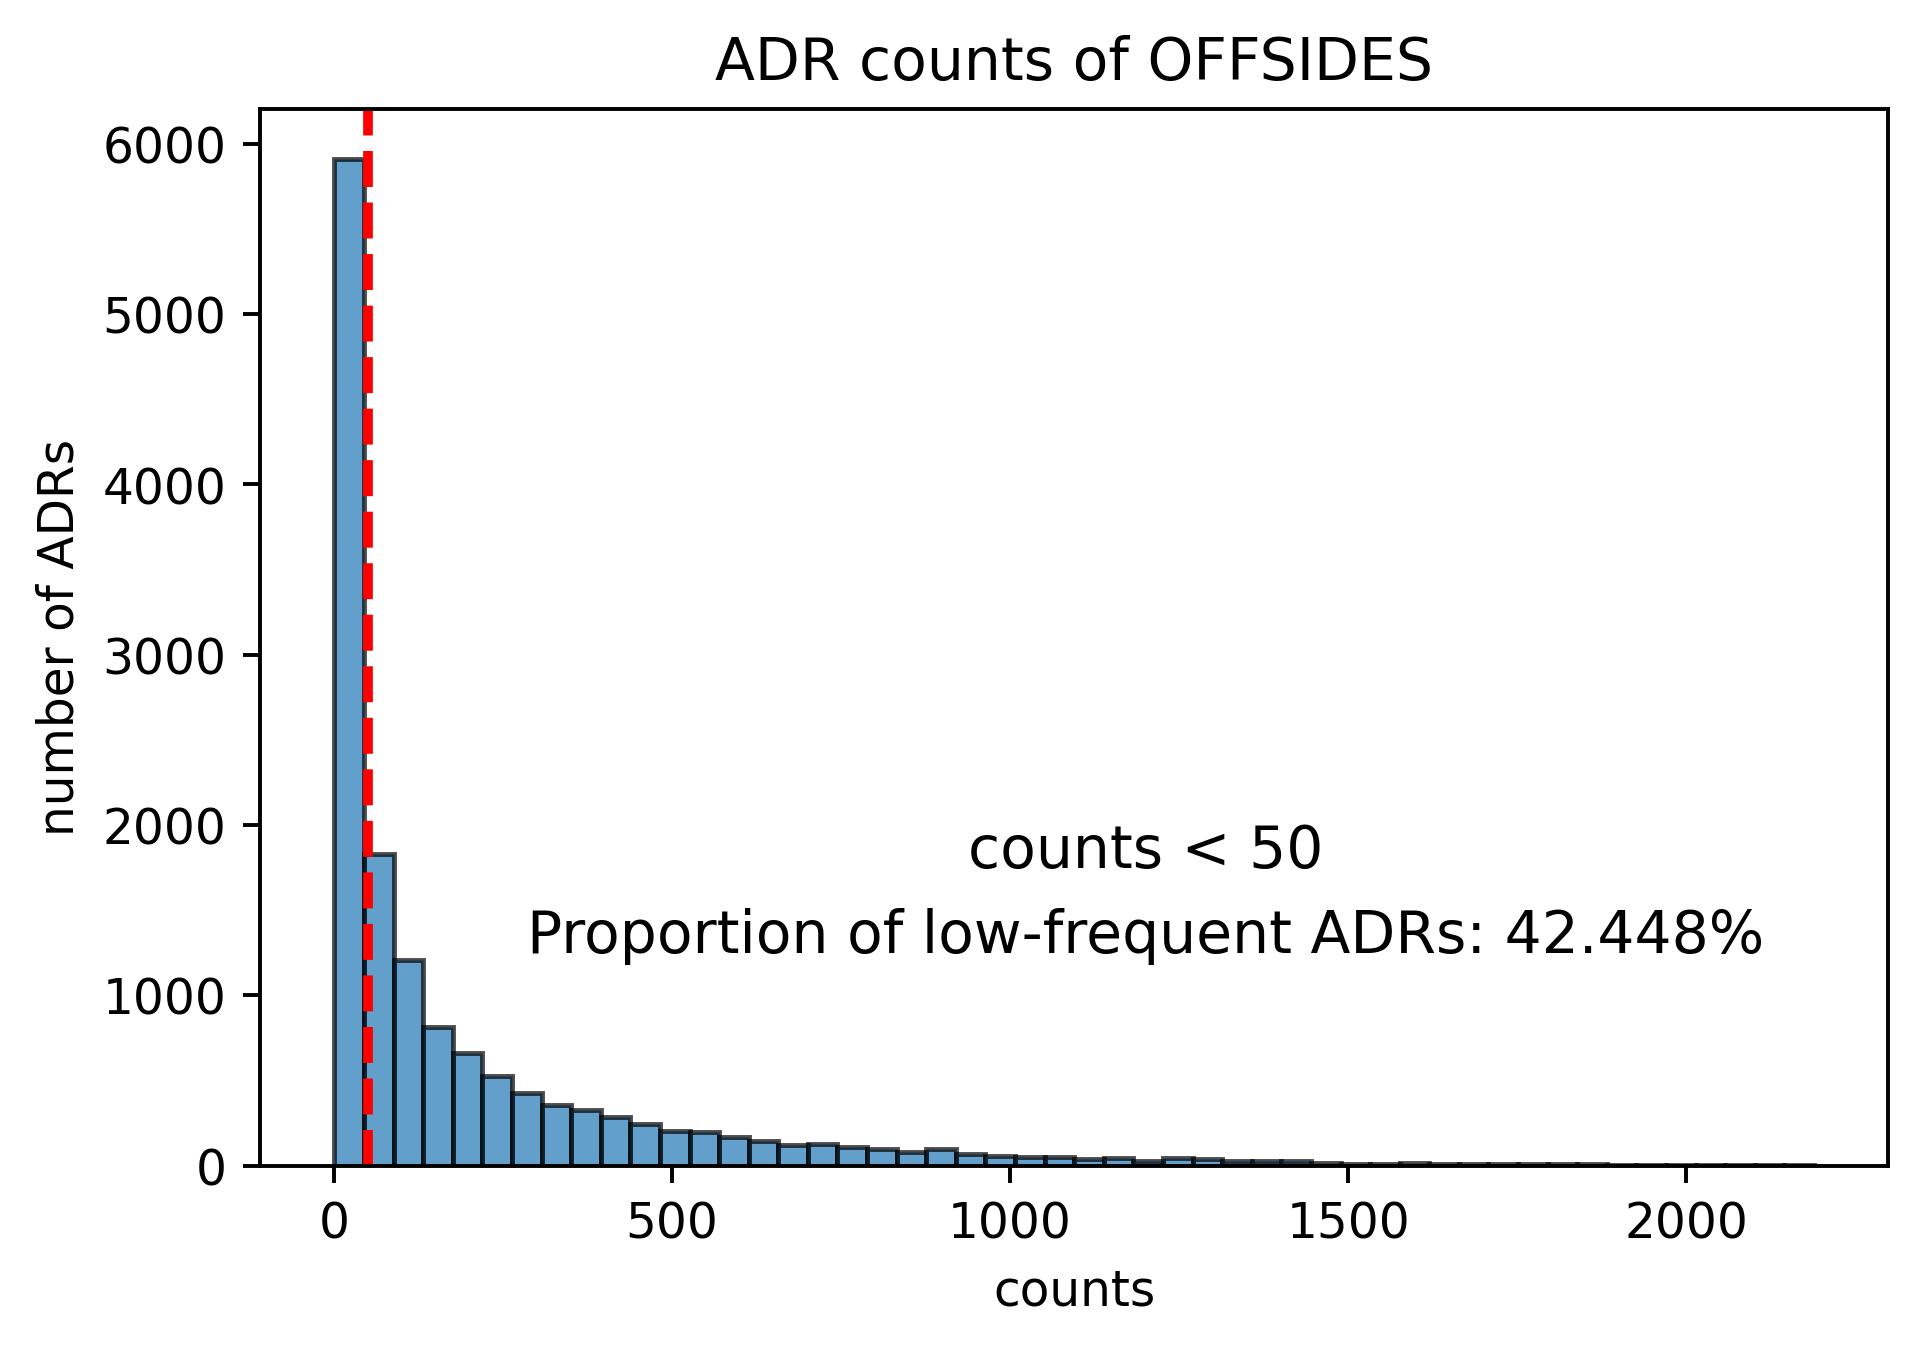

In [25]:
column_sums
plt.figure(dpi=350)
plt.hist(column_sums, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(x=50, color='red', linestyle='--', linewidth=2)
plt.title('ADR counts of OFFSIDES')
plt.xlabel('counts')
plt.ylabel('number of ADRs')
prop = ((column_sums < 50).sum()/len(column_sums)).round(5)*100
plt.text(1200, 1250, f'Proportion of low-frequent ADRs: {prop}%', color='black', fontsize=12, ha='center')
plt.text(1200, 1750, "counts < 50", color='black', fontsize=12, ha='center')

plt.savefig(fname=f"figs/OFFSIDES_rare.jpg", bbox_inches="tight")
plt.show()

## Study how the frequency affects the performance of the method

We used SIDER as ADR data and DGI as feature. 

In [21]:
SEs_name = "SIDER"
metrice = "AUPR"

Load the tuned hyperparameters.

In [ ]:
# Open and read the JSON file
with open(f'results/hyperpars_{SEs_name}.xml', 'r') as xml_file:
    hyperpars = json.load(xml_file)

   
Run Nested CV using different frequencies of ADRs, using KRR. 

1. We first examine how performance changes when using ADRs beyond certain frequency thresholds. The performance curve allows us to infer how common ADRs contribute to performance, whereas noise ADRs do not.

In [51]:
SEs = {}
results = {}
SIDER = Pairs2Mat(path="data/drug_se.tsv",colname1="1_x",colname2="5")
column_sums = np.sum(SIDER, axis=0)
results["KRR"] = {}
results["Naive"] = {}
for i in range(0, 300, 5):
    results["KRR"][i] = {}
    results["Naive"][i] = {}
    SEs["SIDER"] = SIDER.loc[:, (column_sums >= i)]
    
    validation = "nested_cv"
    method = "KRR"
    str = "DGI"
    print(f"using feature {str}")
    results[method][i], _ = evaluation(Y=SEs["SIDER"], X=features_dict[str], method_option=method,tuning_metrice=metrice,hyperparfixed=hyperpars[validation][method][str],Validation=validation, n_jobs=1)

    method = "Naive"
    print(f"using feature {str}")
    results[method][i], _ = evaluation(Y=SEs["SIDER"], X=features_dict[str], method_option=method,tuning_metrice=metrice,Validation=validation,n_jobs=1)

using feature DGI
The KRR requires hyperparameter lambda, sigma_X
---------- nested cv start ----------
Fold: 0
number of hyperpars combination:  25
first few training idx:  [ 49  54  67 117 183 251 258 271 411 712]
first few testing idx:  [ 94 124 142 193 241 339 379 438 651 689]
--- tuning end ---
target size: 150
------ best hyper pars:  (0.1, 10) ------
KRR starts:
KRR ends:
-----------
AUPRperdrug: 0.4403870302633993
AUROCperdrug: 0.9100148691206565
AUPR+AUROCperdrug: 1.3504018993840559
AUPR: 0.400166789881065
AUROC: 0.895499274556988
AUPR+AUROC: 1.2956660644380529
-----------
Fold: 1
number of hyperpars combination:  25
first few training idx:  [ 94 124 142 193 241 339 379 438 651 689]
first few testing idx:  [ 49  54  67 117 183 251 258 271 411 712]
--- tuning end ---
target size: 150
------ best hyper pars:  (0.1, 10) ------
KRR starts:
KRR ends:
-----------
AUPRperdrug: 0.44501046206194855
AUROCperdrug: 0.9150826598561888
AUPR+AUROCperdrug: 1.3600931219181374
AUPR: 0.388533111

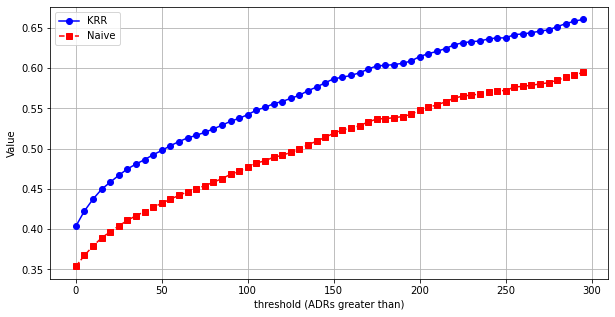

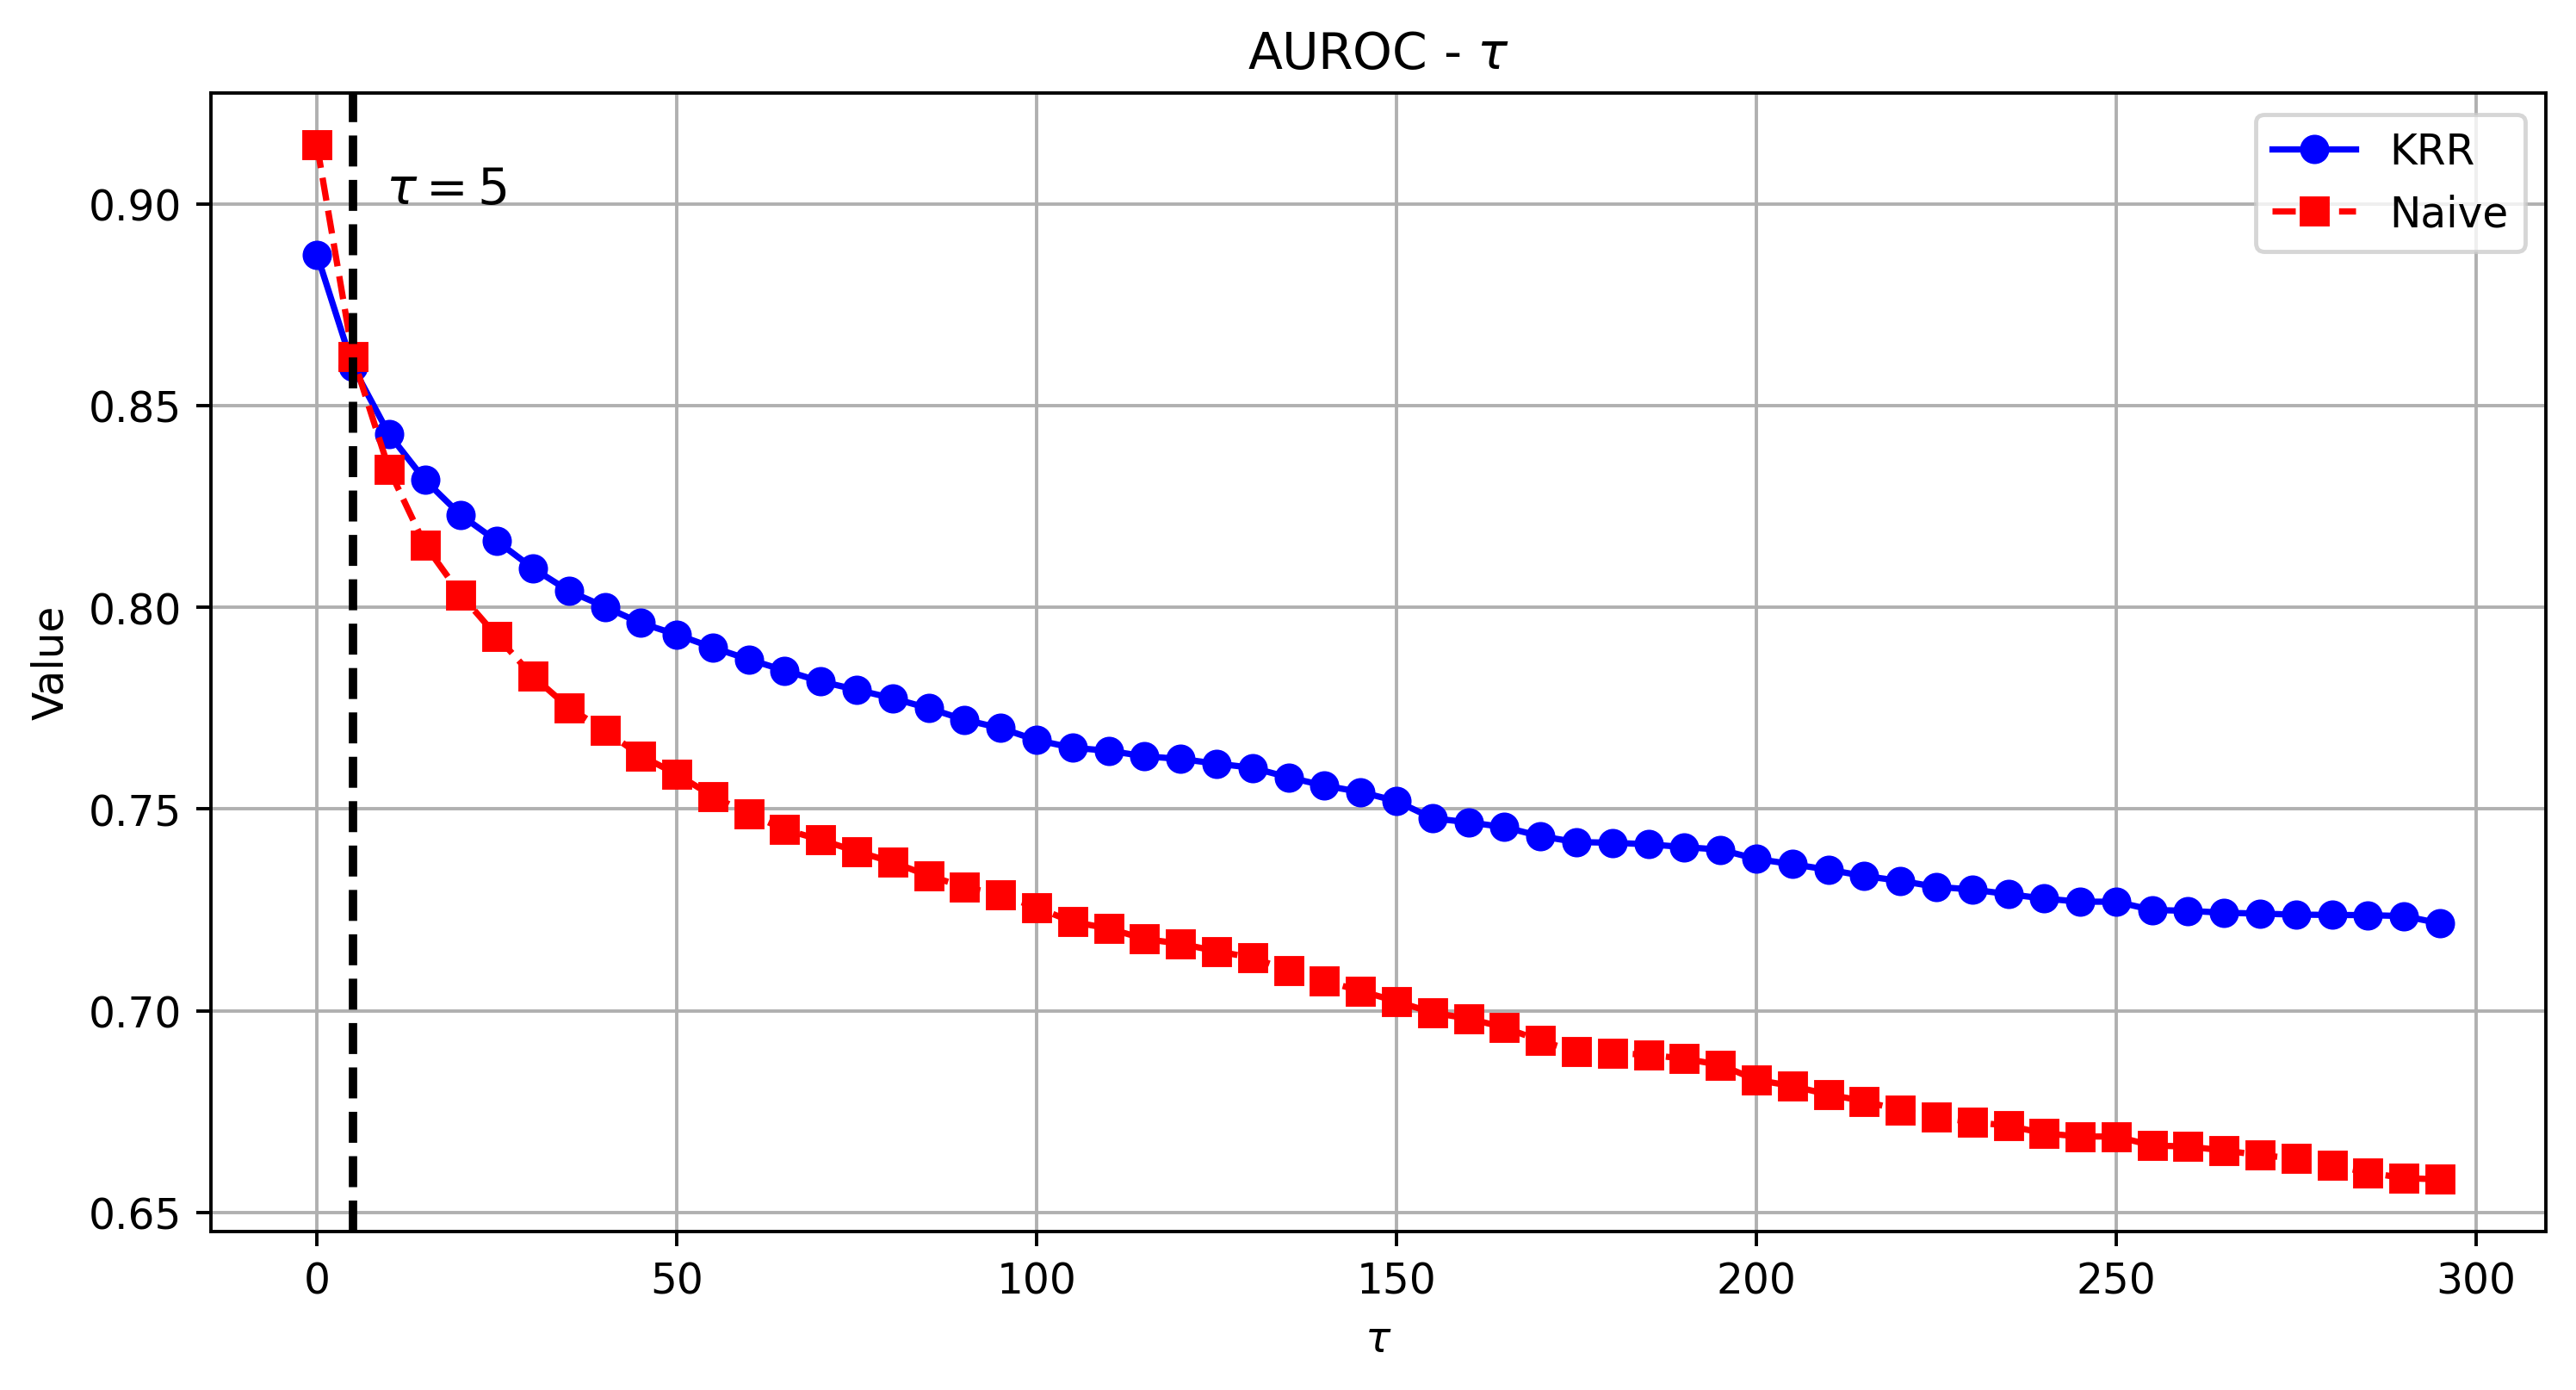

In [74]:

vector1 = []
metrice = "AUPR"
for i in range(0, 300, 5):
    vector1.append(np.array(results["KRR"][i][metrice]).mean())
    vector2 = []
x = []
for i in range(0, 300, 5):
    vector2.append(np.array(results["Naive"][i][metrice]).mean())
    x.append(i)
plt.figure(figsize=(10, 5))

# Plot the first series
plt.plot(x, vector1, marker='o', linestyle='-', color='b', label='KRR')

# Plot the second series
plt.plot(x, vector2, marker='s', linestyle='--', color='r', label='Naive')

# Add titles and labels
# plt.title(f"{metrice}", " - $\{tau}$")
plt.xlabel('threshold (ADRs greater than)')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show grid
plt.grid(True)

# Display the chart
plt.show()

vector1 = []
metrice = "AUROC"
for i in range(0, 300, 5):
    vector1.append(np.array(results["KRR"][i][metrice]).mean())
    vector2 = []
x = []
for i in range(0, 300, 5):
    vector2.append(np.array(results["Naive"][i][metrice]).mean())
    x.append(i)
plt.figure(figsize=(10, 5), dpi=350)

# Plot the first series
plt.plot(x, vector1, marker='o', linestyle='-', color='b', label='KRR')

# Plot the second series
plt.plot(x, vector2, marker='s', linestyle='--', color='r', label='Naive')
plt.axvline(x=5, color='black', linestyle='--', linewidth=2)
# Add titles and labels
plt.title(f"{metrice} - "+"$\\tau$")
plt.xlabel('$\\tau$')
plt.ylabel('Value')
plt.text(18, 0.9, "$\\tau=5$", color='black', fontsize=12, ha='center')
# Add legend
plt.legend()

# Show grid
plt.grid(True)
plt.savefig(fname=f"figs/define_tau.jpg", bbox_inches="tight")
# Display the chart
plt.show()


2. We then study how performance changed using ADRs less than frequency thresholds. 

In [26]:
SEs = {}
SIDER = Pairs2Mat(path="data/drug_se.tsv",colname1="1_x",colname2="5")
column_sums = np.sum(SIDER, axis=0)
results["KRR"] = {}
results["Naive"] = {}
for i in range(5, 305, 25):
    results["KRR"][i] = {}
    results["Naive"][i] = {}
    SEs["SIDER"] = SIDER.loc[:, (column_sums < i)]
    
    validation = "nested_cv"
    method = "KRR"
    str = "DGI"
    print(f"using feature {str}")
    results[method][i], _ = evaluation(Y=SEs["SIDER"], X=features_dict[str], method_option=method,tuning_metrice=metrice,hyperparfixed=hyperpars[validation][method][str],Validation=validation, n_jobs=1)

    method = "Naive"
    print(f"using feature {str}")
    results[method][i], _ = evaluation(Y=SEs["SIDER"], X=features_dict[str], method_option=method,tuning_metrice=metrice,Validation=validation,n_jobs=1)

using feature DGI
The KRR requires hyperparameter lambda, sigma_X
---------- nested cv start ----------
Fold: 0
number of hyperpars combination:  25
first few training idx:  [ 91  96 164 184 261 315 379 433 470 498]
first few testing idx:  [ 78 117 140 292 343 381 401 542 553 565]
--- tuning end ---
target size: 113
------ best hyper pars:  (0.1, 10) ------
KRR starts:
KRR ends:
-----------
AUPRperdrug: 0.03250106567304588
AUROCperdrug: 0.5647942617266507
AUPR+AUROCperdrug: 0.5972953273996966
AUPR: 0.005219135204051869
AUROC: 0.5229937610375358
AUPR+AUROC: 0.5282128962415876
-----------
Fold: 1
number of hyperpars combination:  25
first few training idx:  [ 78 117 140 292 343 381 401 542 553 565]
first few testing idx:  [ 91  96 164 184 261 315 379 433 470 498]
--- tuning end ---
target size: 113
------ best hyper pars:  (0.1, 10) ------
KRR starts:
KRR ends:
-----------
AUPRperdrug: 0.043965607817668194
AUROCperdrug: 0.5530996226141979
AUPR+AUROCperdrug: 0.5970652304318661
AUPR: 0.004

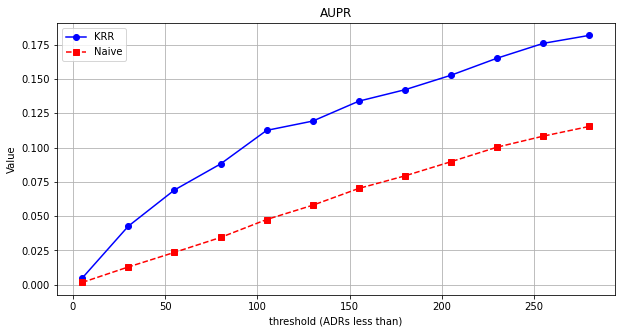

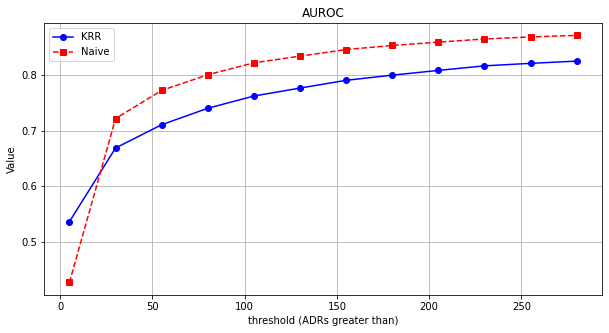

In [27]:

vector1 = []
metrice = "AUPR"
for i in range(5, 305, 25):
    vector1.append(np.array(results["KRR"][i][metrice]).mean())
    vector2 = []
x = []
for i in range(5, 305, 25):
    vector2.append(np.array(results["Naive"][i][metrice]).mean())
    x.append(i)
plt.figure(figsize=(10, 5))

# Plot the first series
plt.plot(x, vector1, marker='o', linestyle='-', color='b', label='KRR')

# Plot the second series
plt.plot(x, vector2, marker='s', linestyle='--', color='r', label='Naive')

# Add titles and labels
plt.title(metrice)
plt.xlabel('threshold (ADRs less than)')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show grid
plt.grid(True)

# Display the chart
plt.show()

vector1 = []
metrice = "AUROC"
for i in range(5, 305, 25):
    vector1.append(np.array(results["KRR"][i][metrice]).mean())
    vector2 = []
x = []
for i in range(5, 305, 25):
    vector2.append(np.array(results["Naive"][i][metrice]).mean())
    x.append(i)
plt.figure(figsize=(10, 5))

# Plot the first series
plt.plot(x, vector1, marker='o', linestyle='-', color='b', label='KRR')

# Plot the second series
plt.plot(x, vector2, marker='s', linestyle='--', color='r', label='Naive')

# Add titles and labels
plt.title(metrice)
plt.xlabel('threshold (ADRs less than)')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show grid
plt.grid(True)

# Display the chart
plt.show()